# Susceptible-Infected (SI) disease spreading model on top of a temporal communication network
we'll implement a SI epidemic spreading model on a temportal network, provided with timestamps for each edge, and we'll analyze the SI model trying to extract interesting and useful conclusions.

### Import libraries

In [48]:
import networkx as nx
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# import utility functions (for plots)
import network_utils as utl

# import other utility functions
from simulation_utils import *

# for plots
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams.update({'font.size': 15})
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.style.use('seaborn-darkgrid')


# set random seed for repeating experiments
random.seed(10)

%load_ext cython

In [2]:
# name of the network file
file_name = "comm-linux-kernel-reply.edges" 

## Read the network

### Explore the Network File
Before actually reading the network, let's visualize how the file containing the network data is structured:

In [3]:
# open file in read mode
with open(file_name, "r") as f:
    # read and print first 15 lines of the file
    for i in range(10):
        line = f.readline()
        print(line)

% asym positive

%This is the communication network of the Linux kernel mailing list. 

% Nodes are persons (identified by their email addresses), and each directed edge represents a reply from a user to another.

33	33	1	1138206644

33	28	1	1138211184

33	28	1	1138213453

28	2	1	1138215043

28	58	1	1138218253

2	58	1	1138218253

58	59	1	1138220449



From the above output we can see that the file contains the edges of a communication network of the Linux kernel mailing list. <br> In particular, nodes are persons (identified by their email addresses), and each directed edge represents a reply from a user to another. The last column represents the timestamp of the mail exchange between two users. <br>
Therefore, the network of interest is a TEMPORAL and DIRECTED network that represents the exchange of mails over time between nodes that represent persons.<br>
Notice that the third column represents the weight of each edge.

To better understand the network and obtain more insights, lets analyze the source nodes, destination nodes and the timestamp ranges:

In [4]:
source_nodes = [] # source nodes lists
destination_nodes = [] # destination nodes
time_stamps = [] # timestamps
comment="%" # starting char of comment lines
delim="\t" # delimiter char

# read file and store nodes and timestamps
with open(file_name, "r") as f:
    for l in tqdm(f):
        
        # Skip comment lines
        if l[0] != comment:
            
            # put edge data into a list of integers
            data = list(map(int, l.strip().split(delim)))
            
            # append to lists
            source_nodes.append(data[0])
            destination_nodes.append(data[1])
            time_stamps.append(data[3])

1096443it [00:02, 499315.63it/s]


In [5]:
print("Total number of edges: {}".format(len(source_nodes)))
print("Total number of source nodes: {}".format(len(set(source_nodes))))
print("Total number of destination nodes: {}".format(len(set(destination_nodes))))
print("Number of different timestamps: {}".format(len(set(time_stamps))))

Total number of edges: 1096440
Total number of source nodes: 25089
Total number of destination nodes: 25212
Number of different timestamps: 881701


It may be interesting to better understand the range of node ids:

In [6]:
# All the nodes of the net
nodes_set = set(source_nodes).union(set(destination_nodes))

In [7]:
# Total number of nodes (persons) in the network
len(nodes_set)

27927

We can print the min and max node ids:

In [8]:
sorted(nodes_set)[0], sorted(nodes_set)[-1]

(1, 63399)

It seems that node identifiers start from 1 up to 63399, but the number of total nodes is 27927, therefore some identifiers are simply not present. <br>We can now take a look at the timestamps:

In [9]:
# sort timestamps
time_stamps_set = sorted(set(time_stamps))

It may be intersting to visualize the smallest and the highest timestamp value, as well as the distribution of timestamps, to better understand those with high mail exchange.

In [10]:
# min and max timestamps
timestamp_min = np.min(time_stamps_set)
timestamp_max = np.max(time_stamps_set)
timestamp_min, timestamp_max

(1136080607, 1388528616)

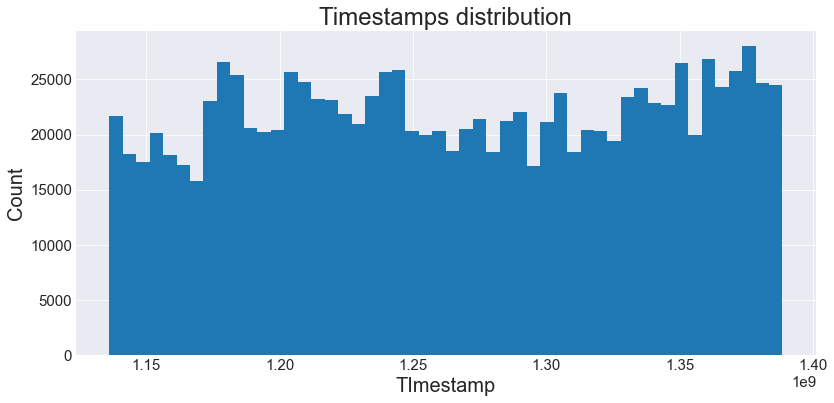

In [11]:
plt.style.use('seaborn-darkgrid')
plt.hist(time_stamps, bins=50)
plt.title("Timestamps distribution")
plt.xlabel("TImestamp")
plt.ylabel("Count")
plt.tight_layout()

We could retrieve the date from the <i>Unix</i> timestamp:

In [12]:
from datetime import datetime

# first and last timestamps
datetime.fromtimestamp(timestamp_min).strftime('%Y-%m-%d %H:%M:%S'), datetime.fromtimestamp(timestamp_max).strftime('%Y-%m-%d %H:%M:%S')

('2006-01-01 02:56:47', '2013-12-31 23:23:36')

This allows us to understand that the network contains email exchanged during 8 full years, from 2006 to 2013, between 27927 users/mails.

### Read temporal and directed network
We'll now read the network by using the networkx function 'read_edgelist', which allows to read directly the .EDGES file specifying some additional arguments as explained in the documentation (PUT LINK). In particular, we'll add to each edge an attribute encoding its weight and another atttribute encoding the timestamp.<br>We therefore read the network as a Directed Network with Multiple edges.

In [13]:
g = nx.read_edgelist("comm-linux-kernel-reply.edges", comments="%", delimiter="\t", create_using = nx.MultiDiGraph(), data=(("weight", int), ("timestamp", int)))

Let's check the correct reading of the networK:

In [14]:
# show type of netwok
print(g)

# check if directed and weighted
print(nx.is_directed(g), nx.is_weighted(g))

MultiDiGraph with 27927 nodes and 1096440 edges
True True


In [15]:
# get edges with corresponding attributes
edges = list(g.edges.data())

In [16]:
# visualize first 10 edges
print(edges[1:10])

[('33', '33', {'weight': 1, 'timestamp': 1137777721}), ('33', '33', {'weight': 1, 'timestamp': 1137778200}), ('33', '33', {'weight': 1, 'timestamp': 1138386487}), ('33', '33', {'weight': 1, 'timestamp': 1136909626}), ('33', '33', {'weight': 1, 'timestamp': 1140713637}), ('33', '33', {'weight': 1, 'timestamp': 1143771296}), ('33', '33', {'weight': 1, 'timestamp': 1143771296}), ('33', '33', {'weight': 1, 'timestamp': 1143820149}), ('33', '33', {'weight': 1, 'timestamp': 1143820214})]


We can clearly see that we have correclty read the network as a directed network with multiple edges and also with self-loops. <br>
What changes between directed edges among the same nodes is the timestamp of of the communication between the nodes.

### Read the network as static
We may be interested in reading the network as a static one, without taking into account the timestamps. 
Let's define an auxiliary function for doing that. <br>
<b>Important remark</b>: if a directed edge appears into two different timestamps, we'll increase the weight by one, without considering the case of multiple edges. <br>
The function for reading the network in that way is implemented in the 'simulation_utils.py' file

In [17]:
from simulation_utils import read_network_static_singular
g2 = read_network_static_singular(file_name)

1096443it [00:04, 249664.67it/s]


Let's save this network for retrieving it without the need of running the function

In [51]:
nx.write_pajek(g2, "g2.net")

Let's inspect for correct reading:

In [18]:
# show type of netwok
print(g2)

# check if directed and weighted
print(nx.is_directed(g2), nx.is_weighted(g2))
#g2.get_edge_data(33, 28) # 33 has mumtiple conections with 28

DiGraph with 27927 nodes and 242976 edges
True True


Notice that now we don't have anymore multiple edges between the same pairs of nodes.

In [19]:
#list of edges with corresponding attributes
edges2 = list(g2.edges.data())

In [20]:
# visualize first 20 edges
print(edges2[1:20])

[(33, 28, {'weight': 4}), (33, 52, {'weight': 1}), (33, 3, {'weight': 3}), (33, 44, {'weight': 1}), (33, 16, {'weight': 3}), (33, 13, {'weight': 1}), (33, 30, {'weight': 2}), (33, 761, {'weight': 1}), (33, 18, {'weight': 1}), (33, 74, {'weight': 4}), (33, 804, {'weight': 2}), (33, 58, {'weight': 3}), (33, 1186, {'weight': 5}), (33, 94, {'weight': 3}), (33, 22, {'weight': 4}), (33, 73, {'weight': 1}), (33, 120, {'weight': 1}), (33, 605, {'weight': 1}), (33, 115, {'weight': 3})]


As clearly shown above, we have now read the network as a directed one, without timestamps and with a weight equal to the cardinality of edges.

A further possibility is to read the network as an undirected one

### Check connectivity

We could check whether the graph is connected or not, in this case we may check for the "strong connectivity", which states that a directed graph is strongly connected if and only if every vertex in the graph is reachable from every other vertex.

In [22]:
# check strong connectivity
nx.is_strongly_connected(g2)

False

We can now check whether the graph is "weakly connected", i.e. if it is connected when the direction of the edge between nodes is ignored.

In [23]:
nx.is_weakly_connected(g2)

False

The graph is not weakly connected.<br>
Let's get the biggest weakly connected component:

In [24]:
biggest_weakly = get_biggest_weakly_connected_component(g2)
print(biggest_weakly)

DiGraph with 24567 nodes and 239825 edges


In [25]:
biggest_strongly = get_biggest_strongly_connected_component(g2)
print(biggest_strongly)

DiGraph with 18531 nodes and 230721 edges


### Network properties
We'll now visualize some of the most important properties of the considered network. <br>We'll consider the stati network g2 to calculate the main descriptors

In [25]:
def get_network_summary(G):
    net_desc = {"name":G.name}

    # Compute all descriptors
    net_desc['n_nodes'] = G.number_of_nodes()
    net_desc['n_edges'] = G.number_of_edges()
    
    degrees_values = [val for key,val in G.degree()] # degree for each node
    net_desc['min_deg'] = np.min(degrees_values)
    net_desc['max_deg'] = np.max(degrees_values)
    net_desc['avg_deg'] = round(np.mean(degrees_values), 4) # 4 decimal digits

    net_desc['avg_clust'] = round(nx.average_clustering(G, weight = 'weight'), 4)
    net_desc['assortativity'] = round(nx.degree_assortativity_coefficient(G, weight = 'weight'), 4)
    
    # since the net is not connected, we consider the average_shortest_path_length of the biggest weakly connecte subgraph
    net_desc['avg_path_len'] = round(nx.average_shortest_path_length(get_biggest_weakly_connected_component(G), weight = 'weight'), 4)
    net_desc['diameter'] = nx.diameter(G)
    
    return net_desc

In [26]:
#print(get_network_summary(g2))

## Plots and distributions

We'll use the plotting functions defined in the 'network_utils.py' Python file

### Degree distribtution histograms
Log-log and linear

In [27]:
#degrees = [g2.degree(n) for n in g2.nodes()]
n_bins = 30 # number of bins to use

#### PDF histograms

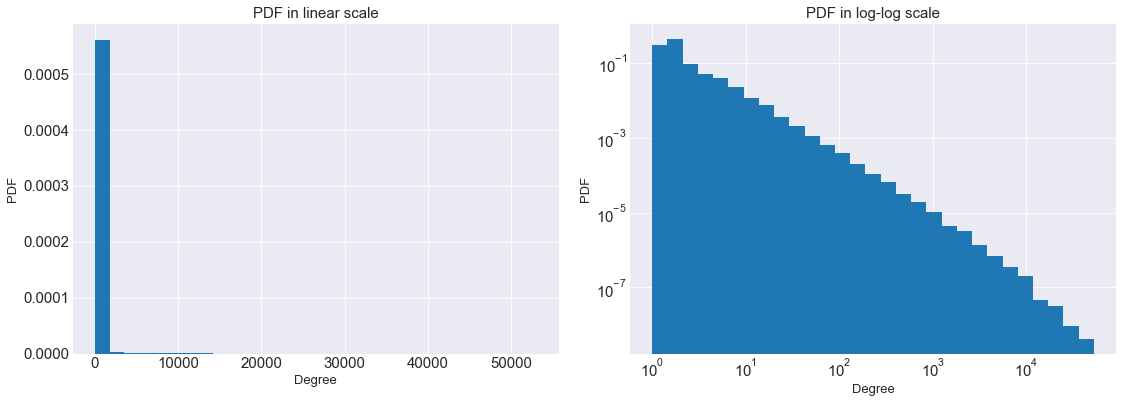

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
utl.plot_linear_PDF(g, name='', nbins = n_bins)
plt.subplot(1, 2, 2)
utl.plot_loglog_PDF(g, name="", nbins = n_bins)

#### CCDF histograms

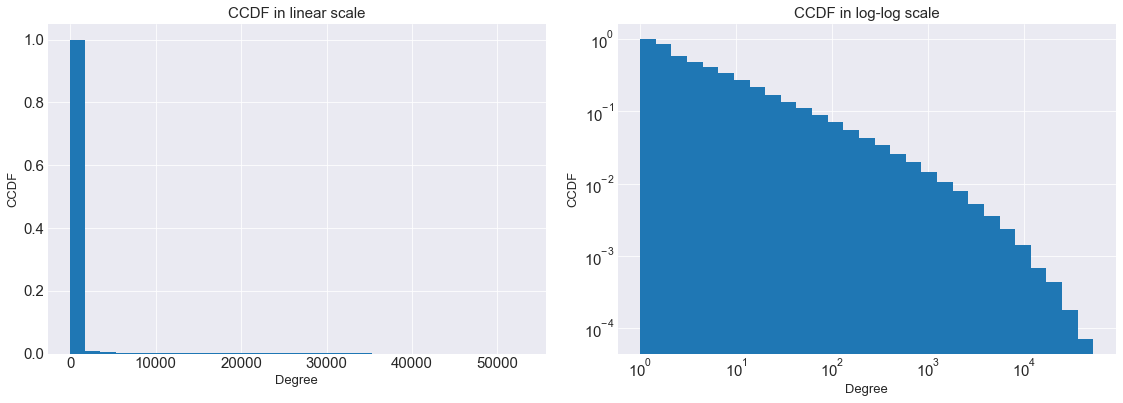

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
utl.plot_linear_CCDF(g, name="", nbins=n_bins)
plt.subplot(1, 2, 2)
utl.plot_loglog_CCDF(g, name="", nbins = n_bins)

From the above plots we can see that the network g follows a powerlaw degree distribution (scale-free network). To better understand it we'll now estimate it's exponent and plot the theorical distribution line

### Estimation of the exponent for the empirical degree distribution

We'll use the MLE estimation of the exponent.

* We can use the <i>powerlaw</i> Python package described here: https://arxiv.org/abs/1305.0215, which is based on a MLE of the exponent of a powerlaw distribution . <br>
As described in the paper https://arxiv.org/abs/0706.1062, the <i>powerlaw</i> package performs the exponent estimation by following the formula 3.7 of the paper. <br>
According to the paper, the first step to perform a maximum likelihood fit to a powerlaw is to determine what portion of the data to fit. A heavy-tailed
distribution's interesting feature is, indeed, the tail and its properties, so if the initial, small values of the data
do not follow a power law distribution we may opt to disregard them. The question is from what
minimal value xmin (Kmin) the scaling relationship of the power law begins. The methods described in the paper of Clauset et al. mentioned above find this optimal value of xmin by creating a powerlaw fit starting from each unique value in the dataset, then selecting the one that results in the minimal Kolmogorov-Smirnov distance, D, between the data and the fit. Therefore the algorithm finds xmin my minimizing D. <br> <br>
* While the maximum likelihood fit to a continous power law can be calculated analytically,
and thus the optimal xmin and resulting fitted parameters can be computed quickly, this is not so for the discrete case. The maximum likelihood fit for a discrete power law is found by numerical optimization,
the computation of which for every possible value of xmin can take time. To circumvent this issue,
powerlaw can use an analytic estimate of gamma, from [https://arxiv.org/abs/0706.1062], which can "give results accurate to about 1% or
better provided xmin ≥ 6".




In [30]:
!pip install powerlaw

In [31]:
import powerlaw

degrees = [g.degree(n) for n in g.nodes()]
results = powerlaw.Fit(degrees, discrete = True)
print("\n\nExponent estimation:")
print(round(results.power_law.alpha, 4))
#print(results.power_law.xmin)

Calculating best minimal value for power law fit
xmin progress: 99%

Exponent estimation:
1.6103


The above method gives us an estimated exponent of 1.6103, we'll now plot the theoretical distribution:

In [ ]:
plt.figure(figsize=(12,4))
plt.style.use('ggplot')
plt.subplot(1, 2, 1)
utl.plot_distrib_lin(graph=g)
plt.subplot(1, 2, 2)
utl.plot_distrib_log(graph=g, fit_line=True, gam=1.6103, expct_lo=3, expct_hi=50, expct_const=50)
plt.show()

### Plot the network
Since the network g has multiple nodes, in order to simplify the plot (and reduce the required time to perform the plotting) we'll use the static network g2 we built before:

In [ ]:
pos = nx.spring_layout(g2)

### Centralities
It could be interesting to visualize centrality values of the nodes.<br>
Let's start by analyzing the degree centrality, by starting from the graph g2:

In [38]:
# degree centrality
deg_centrality = nx.degree_centrality(g2)

In [40]:
# first 10 values of degree centrality
[(k,v) for k,v in deg_centrality.items()][1:10]

[(28, 0.005801045620568646),
 (52, 0.00855833273651794),
 (3, 0.011458855546802264),
 (44, 0.013929671274081502),
 (16, 0.08841223232829622),
 (13, 0.0007161784716751415),
 (30, 0.03631024851392967),
 (761, 0.004261261906467092),
 (18, 0.0006087517009238702)]

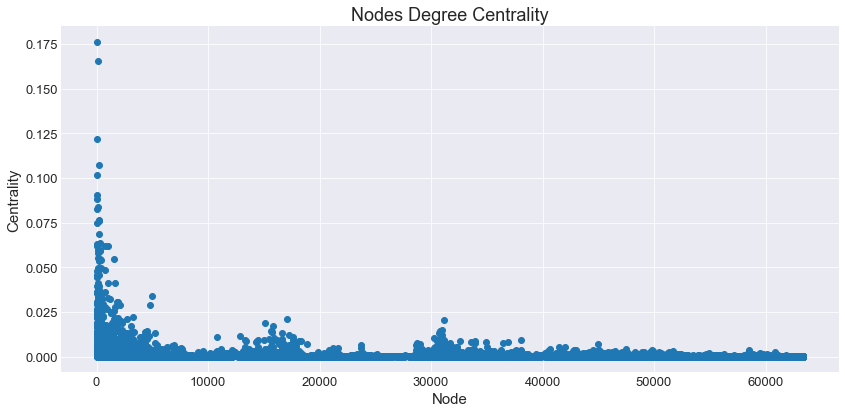

In [41]:
plt.figure(figsize=(12,6))
plt.scatter(deg_centrality.keys(), deg_centrality.values())
plt.title("Nodes Degree Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality")
plt.tight_layout()

In [125]:
import operator

# sort centrality values in descending order
sorted_d = dict( sorted(deg_centrality.items(), key=operator.itemgetter(1),reverse=True))

# get node with highest centrality
c_highest = list(sorted_d.keys())
c_highest[0]

34

In [55]:
%%cython --annotate

import networkx as nx
g2 = nx.read_pajek("g2.net")

# betweenness centrality
bet_centrality = nx.betweenness_centrality(g2)

KeyboardInterrupt: 

Let's visualize the plot of the betweenness centrality:

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(bet_centrality.keys(), bet_centrality.values())
plt.title("Nodes Betweenness Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality")
plt.tight_layout()

Eigenvector centrality:

In [ ]:
eig_centrality = nx.eigenvector_centrality(g2)

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(eig_centrality.keys(), eig_centrality.values())
plt.title("Nodes Eigenvector Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality")
plt.tight_layout()

We can see that most central nodes are the initial 'seed' nodes, i.e. the ones constituting the complete graph from which we started building the preferential attachment mechanism. <br>Therefore, this is an expected behaviour, according to our implementation of the BA algorithm and reflects the properties of BA networks, characterized by a few central sink nodes.

We can even compare the 3 considered centralities:

In [ ]:
plt.figure(figsize=(16,8))
plt.scatter(bet_centrality.keys(), bet_centrality.values(), marker='*', label="degree")
plt.scatter(deg_centrality.keys(), deg_centrality.values(), marker='o', label="betweenness")
plt.scatter(eig_centrality.keys(), eig_centrality.values(), marker='+', label="eigenvector")
plt.title("Comparison of different centrality measures")
plt.xlabel("Node")
plt.ylabel("Centrality")
plt.legend()
plt.tight_layout()

NameError: name 'bet_centrality' is not defined

<Figure size 1152x576 with 0 Axes>

## Communities

To better analyze and understand the considered network, we can apply some community detection algorithms for detecting communities.

## Implementation of a Susceptible-Infected (SI) disease spreading model
We'll now implement a SI spreading model on top of the considered <b>temporal</b> network, containing information about the timestamps of exchange of emails between users. <br>
We will perform a study of the dynamics of the spreading and how it depends on where the process starts as well as the infectivity of the virus. <br>
We'll then use some network centrality measures (the ones we defined before) to understand the roles played by specifing nodes. This will allow us to analyze the speed of spreading and other dynamics by taking into account some specific nodes.

### SI model
In a SI model, each node can assume a state that is either:
* Susceptible (S)
* Infected (I)

When an infected node gets in contact with a susceptible node, this last one may become infected with a probability p in [0,1], which indicates the infectivity of the disease. 
Notice that in the case of a mail network we consider a spam mail setting (detail better the process......). <br>
An important characteristics about the SI model is that infected nodes remain infected forever. <br><br>
In our specific temporal network, nodes are users (i.e. mails) and timestamped connnections represent exchange of mails between them. <br>
We'll take into consideration several hypoteses and perform different experiments.

* In particular, we'll consider an initial node (the <i>seed</i> node of the disease spreading) as the only infected node at the beginning, or we may also consider a group of nodes. Then, following the SI process, an email from an infected person (i.e. computer) may infect its susceptible destination with probability p in [0,1].
Infected nodes will remain infected for the rest of the simulation, and the simulation will be performed according to the provided timestamps.

###  Read  the timestamped network for the simulation
In order to simplify the SI simulation, we'll use an auxiliary function that reads the network in a convenient way for our taks:
* the function under consideration (<i>'read_network_temporal'</i>, implemented in the 'simulation_utils.py') reads the edges from our network file and builds a dictionary data structure where keys are represented by timestamps (ordered in increasing order), and each key points to the list of edges/contacts between pair of nodes that exchanged a mail message in that specific timestamp.<br>

In [56]:
td, nodes = read_network_temporal(file_name) # returns dictionary and set of network nodes

# sort dictionary by timestamps
#td = dict(sorted(td.items()))
n_nodes = len(nodes)

In [57]:
# check if dictionary is sorted
ts = list(td.keys())

flag = 0
if(all(ts[i] <= ts[i + 1] for i in range(len(ts)-1))):
    flag = 1
flag # returns 1 if sorted

1

In [58]:
# print the dictionary
print([(k,v) for k,v in td.items()][:10])

[(1136080607, [(764, 91)]), (1136081011, [(91, 764)]), (1136092142, [(764, 91)]), (1136100742, [(11, 11)]), (1136105481, [(55, 3479)]), (1136110383, [(1005, 3476)]), (1136110707, [(3476, 165)]), (1136111172, [(3479, 55)]), (1136111849, [(165, 3476)]), (1136112590, [(3476, 1005), (165, 1005)])]


We have now everything ready for performing our SI simulations

### Simulation loop
We'll now check the 'simulate_SI' function defined in 'simulation_utils' and performing a single SI simulation loop

In [61]:
seed = [1, 2, 5] # list of seed nodes

rho_, infection_times = simulate_SI(td, seed, nodes, n_nodes, 0.2) # returns rho list and nodes infectiion time

Let's check the prevalence plot

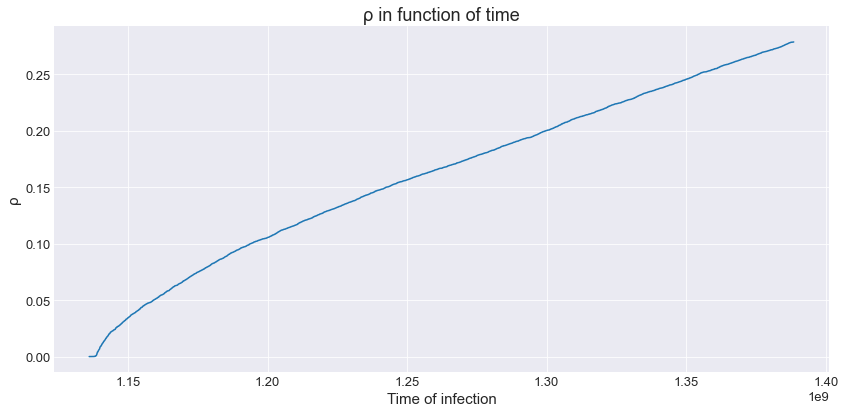

In [76]:
plt.plot(ts, rho_)
plt.title("ρ in function of time")
plt.xlabel("Time of infection")
plt.ylabel("ρ")
plt.style.use('seaborn-darkgrid')
plt.tight_layout()


We can plot the time of infection also by visualizing the time from the beginning of the virus:

In [77]:
# convert timestamps
ts_from_zero = [(t - timestamp_min) for t in ts]

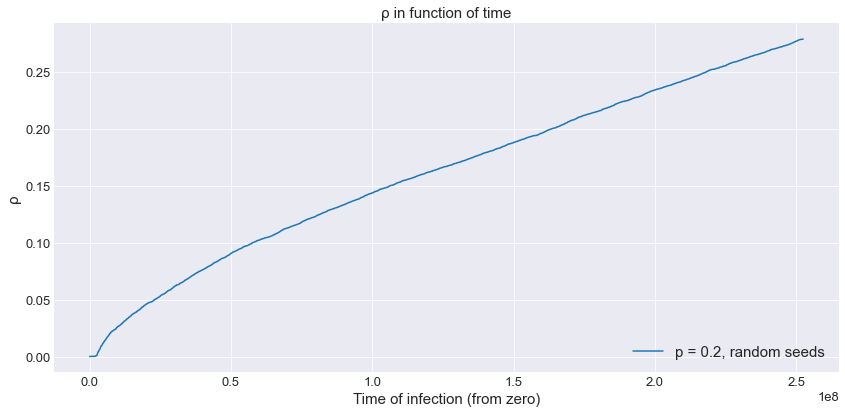

In [78]:
plot_prevalence(ts_from_zero, rho_lists=[rho_], labels=['p = 0.2, random seeds'])

We can plot the scatter plot with the nodes infection times

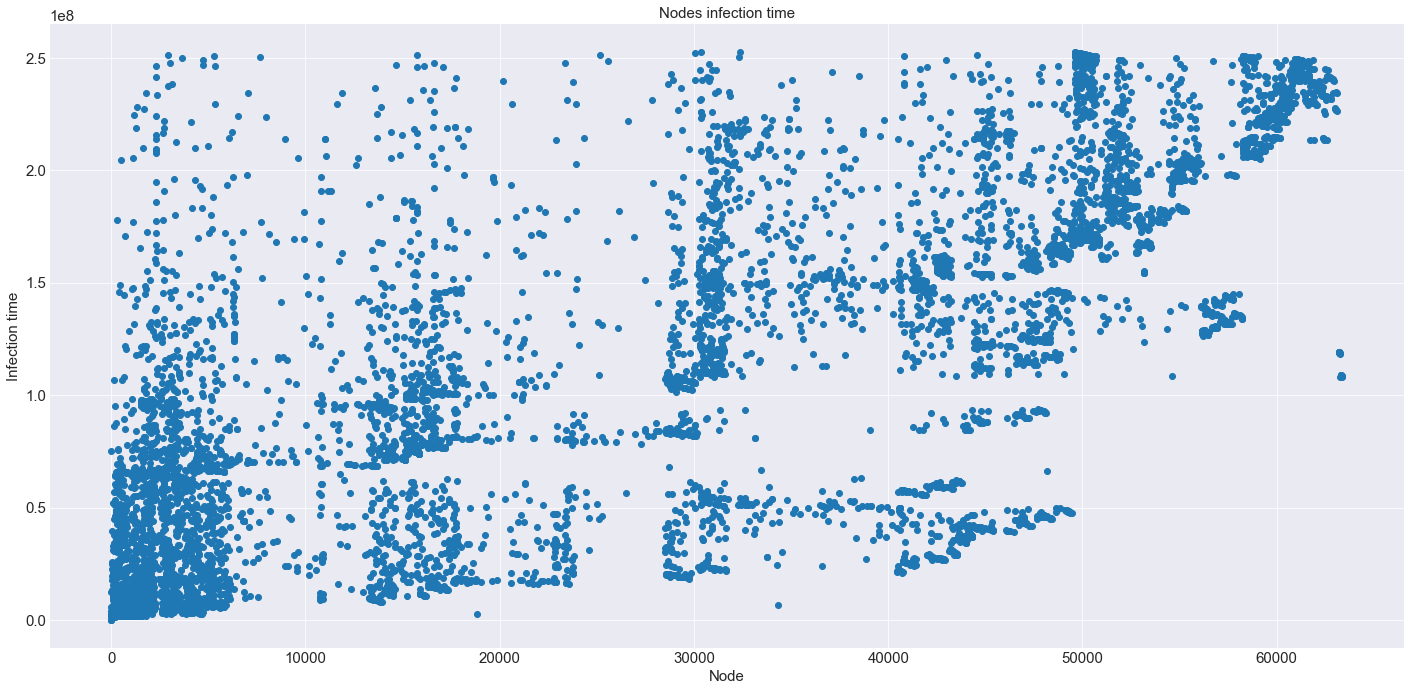

In [23]:
plt.figure(figsize=(20,10))
infection_times_from_zero = [(v- timestamp_min) for v in infection_times.values()]
plt.scatter(sorted(nodes),infection_times_from_zero)
plt.title("Nodes infection time", fontsize=15)
plt.xlabel("Node", fontsize=15)
plt.ylabel("Infection time", fontsize=15)
plt.tight_layout()

We can run multiple SI simulations and average the results to reduce the variance due to the p parameter. <br>The function is defined in the 'simulation_utils.py' file 

In [81]:
import simulation_utils
rho = run_multiple_simulations(20, td, seed, nodes, n_nodes, 0.3)

100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


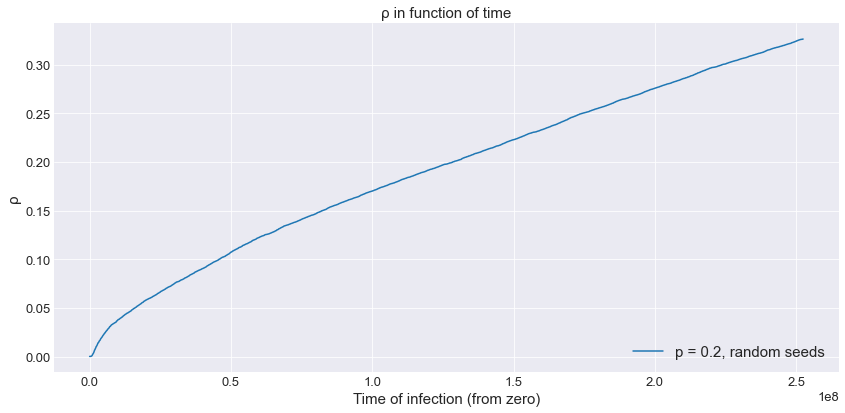

In [82]:
plot_prevalence(ts_from_zero, rho_lists=[rho], labels=['p = 0.2, random seeds'])

# Experiments
We can run our experiments on top of the above defined functions

In order to prevent the disease from spreading to the whole email net, you may immunize some nodes.
---> compare diffrent strategies:
        -- immunization of random nodes
        -- immunization of nodes with the largest values of the four measures of centrality/importance used above
        (use e.g. p = 0.5 and average the results over 20 runs of the model for each immunization strategy)
        N.B. To reduce the variance due to selection of seed nodes, use same seed nodes for investigating all immunization strategies. (first select your immunized nodes, and then select 20 random seed nodes such that none of them belongs to the group of immunized nodes in any of the five different strategies)
        
---> Plot the prevalence(rho) of the disease as a function of time for the 5 different immunization strategies, always immunizing 10 nodes.

RESULTS:
- Which of the immunization strategies performs the best, and why?
- Why betweenness centrality performs better as an immunization strategy than as a predictor of safe hiding place=

Analyze the role of links:
adapt the code to record the number of times that each link transmits the disease to another node. We can do this by simply storing for each node form which other node it obtained the infection.

Run 20 simulations using random nodes as seeds and p = 0.5. For each simulation, record
which links are used to infect yet uninfected nodes (either by first infection-carrying
mails(edges) arriving to susceptible nodes or by infecting edges(mails) arriving before the already
recorded infection time)
Run the simulations, and compute the fraction of times that each link is used for
infecting the disease (fij )

Create scatter plots showing fij as a function of the following link properties:
i) link weight wij
8
ii) unweighted link betweenness centrality ebij (edge betweenness centrality in
networkx)
Compute also the Spearman correlation coefficients between fij and the two link-wise
measures.

Further extension: change probability of infection making it proportional to the edge weight?????

## Experiment 1
The goal of this test is to analyze the case in which p=1, i.e. the virus is always transmitted.
We'll perform the test for 5 random seed nodes and plot the combined plot.<br>
For each seed we'll run the simulation 20 times. 

In [46]:
seed_list = random.sample(nodes, 5)
seed_list

[43888, 21932, 1287, 15456, 29076]

In [47]:
rho_list = [] # rho of each simualation
for seed in seed_list:
    seed = [seed]
    r = run_multiple_simulations(20, td, seed, nodes, n_nodes, 1.0)
    rho_list.append(r)

100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Prevalence plot:

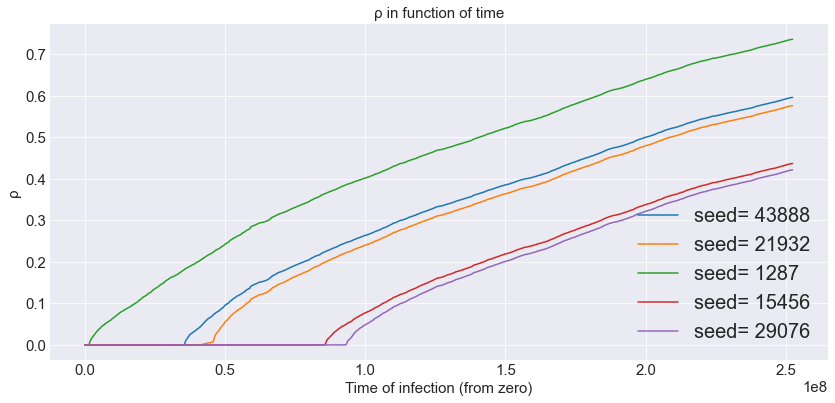

In [50]:
labels = ["seed= " + str(seed) for seed in seed_list]
plot_prevalence(ts_from_zero, rho_list, labels=labels)

## Experiment 2
The goal of this test is to analyze the effect of infection probability p on the spreading speed of the virus. <br>
We'll run our SI model 20 times for each value of the infection probability and we'll use as seed node the node number 34 which is the one with higest degree centrality.<br>

In [97]:
inf_probabilities = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]
rho_list = []
seed = [34] # seed node
for p in inf_probabilities:
    r = run_multiple_simulations(20, td, seed, nodes, n_nodes, p)
    rho_list.append(r)

100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Prevalence plot:

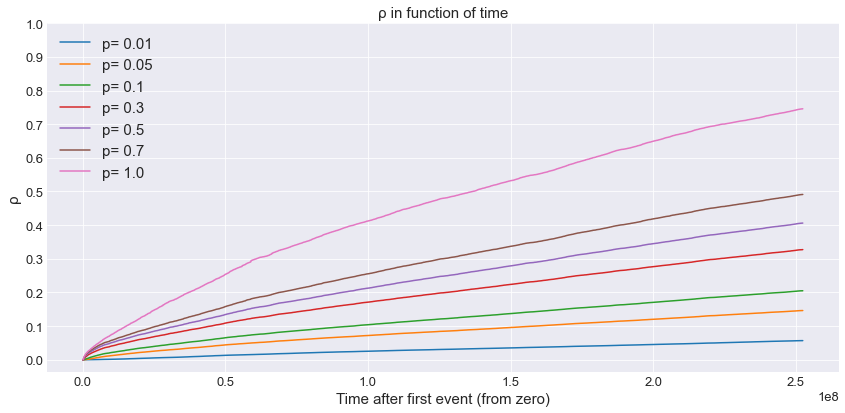

In [123]:
labels = ["p= " + str(p) for p in inf_probabilities]
plot_prevalence(ts_from_zero, rho_list, labels=labels)

The plot shows how an higher infection probability allows to reach an higher number of infected node, and also determines a faster speed in the infection propagation, as it can be seen in the very firts timesteps after gthe spreading, where the pink curve clearly grows very quickly.

It could be interesting to visualize the finual value of ρ(t) in each of the cases:

In [115]:
for r in rho_list:
    print(round(r[-1]*100,2))

5.69
14.62
20.51
32.73
40.61
49.12
74.57


With p=1.0 the ρ(t) reaches a value of almost 75%, meaning that 75% of all the nodes of the network get infected.

## Experiment 3
The goal of this test is to better investigate the effect of the initially infected seed node on the spreading speed of the virus. <br>
Again, we'll run the simulation 20 times for each different seed node, and we'll fix p=0.1.<br>
We'll use 5 different seed nodes: the node with highest degree centrality and the 4 randomly.

In [143]:
# build list of different seeds
seed_list = random.sample(nodes, 4)
seed_list.append(c_highest[0])
seed_list

[22021, 32535, 37367, 59805, 34]

In [144]:
rho_list = [] # rho of each simualation
for seed in seed_list:
    seed = [seed]
    r = run_multiple_simulations(20, td, seed, nodes, n_nodes, 0.1)
    rho_list.append(r)

100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Prevalence plot:

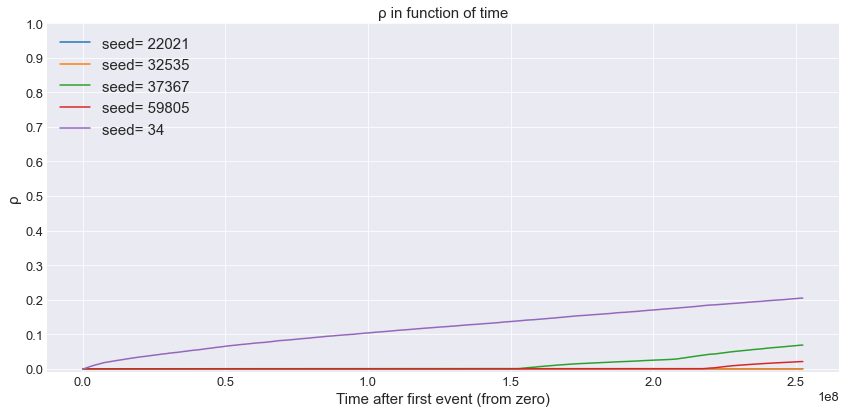

In [145]:
labels = ["seed= " + str(seed) for seed in seed_list]
plot_prevalence(ts_from_zero, rho_list, labels=labels)

An interesting aspect that emerges from the above plot is that the main differences in spreading speed between different seed nodes are mostly visible at the beginning of the virus spreading. This is basically due to two aspects: 
* the spreading speed is faster if the first node is more connected
* it is faster also becuase of the timestamps of contacts between nodes: as we can imagine the node number 59805 starts to spread the virus after many timestemps, and this is due to the fact that it start contacting other nodes a lot of time after the beginning of the virus spreading. <br>

As an overall conclusion for this experiment, we can say that the prevalence of the disease may change remarkably depending on the seed node.

## Experiment 4
With this experiment we would like to find most 'protected' nodes, i.e. those nodes (persons/mails) that are generally more prone to not get the infection.<br>
In order to understand this aspect, we decide to run the SI model 100 times (each time we'll average 10 simulations) with a fixed infection probability of 0.5, and by using at each time a different random seed node.<br> 
We'll record the median infection time for each one of the nodes of the network, that will allow us to show interesting properties about each one of the nodes.

In [151]:
seed_list = random.sample(nodes, 100)
rho_list = [] # rho of each simulation
inf_time_list = [] # infection times of each simulation

# run simulations
for seed in seed_list:
    seed = [seed]
    r, t = run_multiple_simulations2(10, td, seed, nodes, n_nodes, 0.1)
    rho_list.append(r)
    inf_time_list.append(t)

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


TypeError: 'dict_values' object is not subscriptable

Run the SI model 50 times with p=0.5 using different random nodes as seeds and record the MEDIAN infection time for each node.
--> Create scatter plots showing the median infection time of each node as a function of:
        - (unweighted)clustering coefficient c
        - degree k
        - strength 
        - (unweighted) betweenness centrality
This will allow to spot correlations between infection times and various coefficients

??? Use the Spearman rank-correlation coefficient (availble in scipy) for finding out which of the measures is the best predictor for the infection times

Based on the above results, which measure(s) would you use to pick the place to hide, i.e. whihc measure best predicts the infection time? Why?
Why betweenness centrality behaves differently than degree and strength
Why clustering coeff is a poor predictor